# Diagnostic Notebook
This notebook is designed to:
1.  Compare the raw data schemas of Train vs Test.
2.  Analyze the statistical discrepancies between Train and Test features.
3.  Identify potential "Covariate Shift" that might be hurting model performance.
4.  Review Feature Importance to prioritize fixes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import sys
import os

# Add project root to path
sys.path.append(os.path.abspath(".."))

# Import feature engineering logic
import src.features
from src.features import extract_user_attributes, aggregate_user_features

pd.set_option('display.max_columns', None)
print("Libraries Imported.")

Libraries Imported.


In [2]:
# Load Raw Data
train_raw_path = '../data/train.parquet'
test_raw_path = '../data/test.parquet'

print(f"Loading Train: {train_raw_path}")
train_df_raw = pd.read_parquet(train_raw_path)

print(f"Loading Test: {test_raw_path}")
test_df_raw = pd.read_parquet(test_raw_path)

print(f"Train Shape: {train_df_raw.shape}")
print(f"Test Shape: {test_df_raw.shape}")

Loading Train: ../data/train.parquet
Loading Test: ../data/test.parquet
Train Shape: (17499636, 19)
Test Shape: (4393179, 19)


In [3]:
# Compare Raw Headers
train_cols = set(train_df_raw.columns)
test_cols = set(test_df_raw.columns)

print("--- Column Comparison ---")
print(f"Columns in Train only: {train_cols - test_cols}")
print(f"Columns in Test only: {test_cols - train_cols}")

print("\n--- Data Type Comparison ---")
common_cols = train_cols.intersection(test_cols)
mismatched_types = []
for col in common_cols:
    dtype_train = train_df_raw[col].dtype
    dtype_test = test_df_raw[col].dtype
    if dtype_train != dtype_test:
        mismatched_types.append((col, dtype_train, dtype_test))

if mismatched_types:
    print("Mismatched Types found:")
    for col, dt_tr, dt_te in mismatched_types:
        print(f"  {col}: Train={dt_tr}, Test={dt_te}")
else:
    print("All common columns have matching data types.")

--- Column Comparison ---
Columns in Train only: set()
Columns in Test only: set()

--- Data Type Comparison ---
All common columns have matching data types.


In [4]:
# Apply Feature Engineering
print("Applying Feature Engineering to Train...")
train_df_raw = extract_user_attributes(train_df_raw)
train_features = aggregate_user_features(train_df_raw)

print("Applying Feature Engineering to Test...")
test_df_raw = extract_user_attributes(test_df_raw)
test_features = aggregate_user_features(test_df_raw)

# Align Columns (Test should match Train)
# Drop target from train for comparison
X_train = train_features.drop(columns=['target'])
if 'target' in test_features.columns:
    test_features = test_features.drop(columns=['target'])

# Ensure Test has all Train columns (fill missing with 0)
missing_cols = set(X_train.columns) - set(test_features.columns)
for c in missing_cols:
    test_features[c] = 0

# Drop extra columns in Test
extra_cols = set(test_features.columns) - set(X_train.columns)
test_features = test_features.drop(columns=extra_cols)

# Reorder
test_features = test_features[X_train.columns]

print(f"Processed Train Shape: {X_train.shape}")
print(f"Processed Test Shape: {test_features.shape}")

Applying Feature Engineering to Train...
Applying Feature Engineering to Test...
Processed Train Shape: (19140, 46)
Processed Test Shape: (2904, 46)


In [5]:
# Analyze Statistical Discrepancies
print("Calculating Statistics...")
train_stats = X_train.describe().T[['mean', 'std']]
test_stats = test_features.describe().T[['mean', 'std']]

comparison = train_stats.join(test_stats, lsuffix='_train', rsuffix='_test')
comparison['diff_mean_pct'] = abs((comparison['mean_train'] - comparison['mean_test']) / (comparison['mean_train'] + 1e-9))

print("\nTop 15 Mismatched Features (by Mean % Diff):")
print(comparison.sort_values(by='diff_mean_pct', ascending=False).head(15)[['mean_train', 'mean_test', 'diff_mean_pct']])

# Specific check for the "Enormous" ones
print("\nSpecific Check (Errors & Sessions):")
cols_check = ['errors_per_song', 'total_sessions', 'is_error']
print(comparison.loc[[c for c in cols_check if c in comparison.index]][['mean_train', 'mean_test', 'diff_mean_pct']])

Calculating Statistics...

Top 15 Mismatched Features (by Mean % Diff):
                              mean_train      mean_test  diff_mean_pct
errors_per_song                 0.001291       0.265385     204.502165
total_sessions                 10.885998      61.310606       4.632061
is_error                        0.903553       1.530647       0.694032
errors_last_30d                 0.671996       1.005510       0.496303
is_thumbs_down                  8.618809      12.178719       0.413040
length                     185709.126418  262268.563798       0.412255
is_song                       746.678840    1054.342631       0.412043
is_thumbs_up                   41.242999      57.627755       0.397274
errors_last_14d                 0.391588       0.524793       0.340166
downgrade                       0.191797       0.256543       0.337572
is_ad                          14.881766      19.538912       0.312943
listen_time_last_30d       138212.943062  179636.214869       0.299706
songs

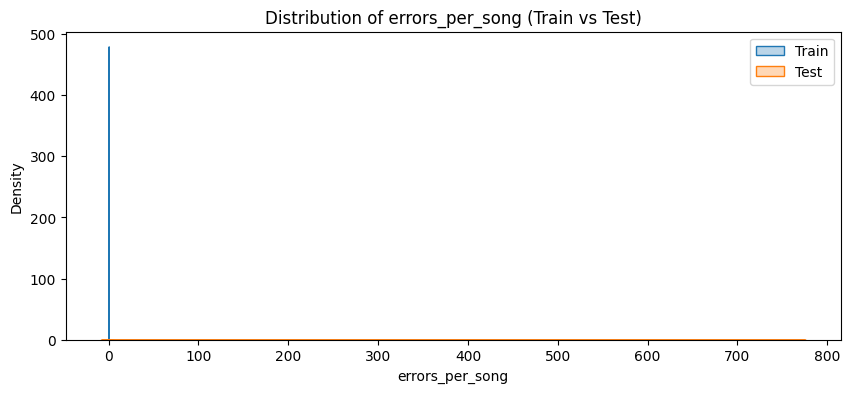

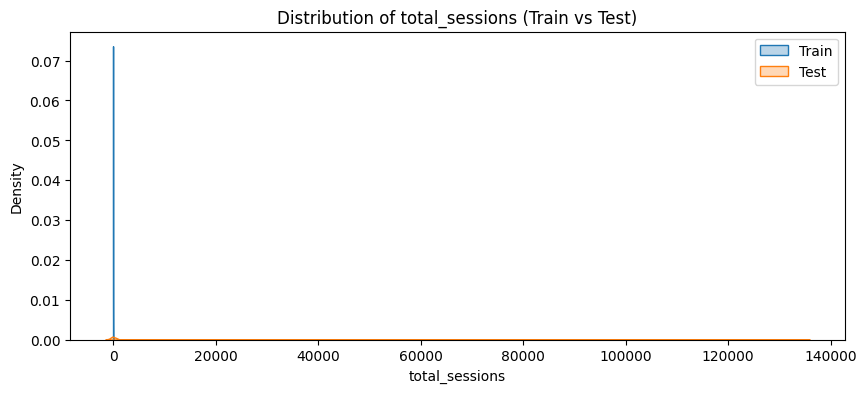

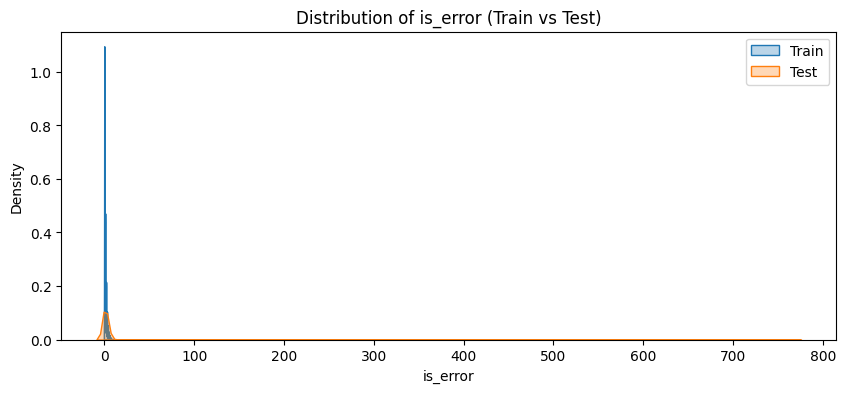

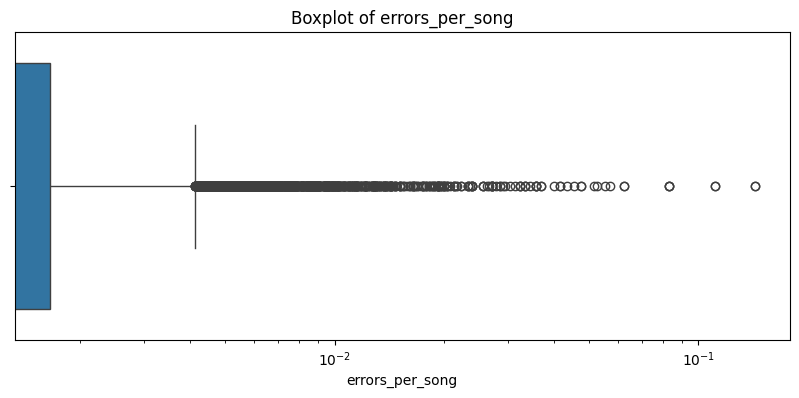

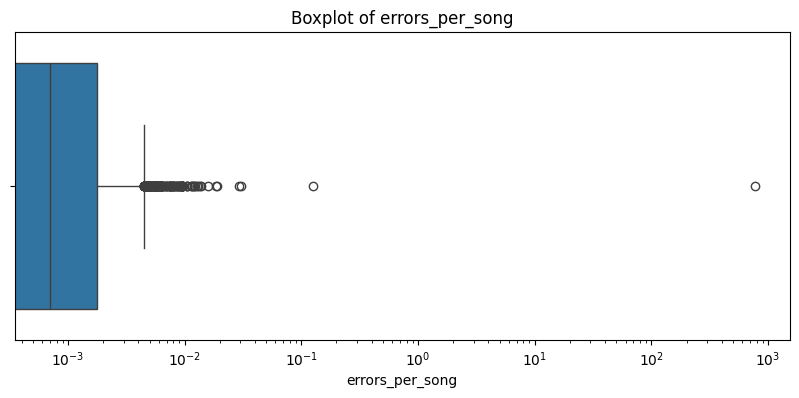

In [13]:
# Visualize Distribution Differences
# We plot the top 3 mismatched features to see the shape of the problem
top_mismatches = comparison.sort_values(by='diff_mean_pct', ascending=False).head(3).index.tolist()

for col in top_mismatches:
    plt.figure(figsize=(10, 4))
    sns.kdeplot(X_train[col], label='Train', fill=True, alpha=0.3)
    sns.kdeplot(test_features[col], label='Test', fill=True, alpha=0.3)
    plt.title(f"Distribution of {col} (Train vs Test)")
    plt.legend()
    plt.show()

# Boxplot for errors_per_song to see outliers
plt.figure(figsize=(10, 4))
sns.boxplot(data=X_train['errors_per_song'], orient='h')
plt.title("Boxplot of errors_per_song")
plt.xscale('log') # Log scale because of the massive outlier
plt.show()

plt.figure(figsize=(10, 4))
sns.boxplot(data=test_features["errors_per_song"], orient="h")
plt.title("Boxplot of errors_per_song")
plt.xscale("log")  # Log scale because of the massive outlier
plt.show()